- This notebook shows how is possible to calculate the output pressure given u_in for breath_ids, using only PID theory.
- This notebook explores only PID terms: P > 0 and I = 0.

In [1]:
import numpy as np
import pandas as pd
import gc
import os
import random
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

train['dcount'] = train.groupby('breath_id')['id'].transform('cumcount')
test['dcount'] = test.groupby('breath_id')['id'].transform('cumcount')

train['uo'] = 80 - train.groupby('breath_id')['u_out'].transform('sum')
test['uo'] = 80 - test.groupby('breath_id')['u_out'].transform('sum')

train['time_delta'] = (train['time_step'] - train.groupby('breath_id')['time_step'].shift(1)).fillna(0)
test['time_delta'] = (test['time_step'] - test.groupby('breath_id')['time_step'].shift(1)).fillna(0)

print(train.shape)
train.head()

(6036000, 11)


,id,breath_id,R,C,time_step,u_in,u_out,pressure,dcount,uo,time_delta
0,1,1,20,50,0.000000,0.083334,0,5.837492,0,30,0.000000
1,2,1,20,50,0.033652,18.383041,0,5.907794,1,30,0.033652
2,3,1,20,50,0.067514,22.509278,0,7.876254,2,30,0.033862
3,4,1,20,50,0.101542,22.808822,0,11.742872,3,30,0.034028
4,5,1,20,50,0.135756,25.355850,0,12.234987,4,30,0.034213


In [3]:
oof = pd.read_csv('../input/ventmodels/train-blend-1.csv')
oof.columns = ['id', 'pred']
train = train.merge(oof, on='id', how='left')
train

,id,breath_id,R,C,time_step,u_in,u_out,pressure,dcount,uo,time_delta,pred
0,1,1,20,50,0.000000,0.083334,0,5.837492,0,30,0.000000,5.964036
1,2,1,20,50,0.033652,18.383041,0,5.907794,1,30,0.033652,5.949975
2,3,1,20,50,0.067514,22.509278,0,7.876254,2,30,0.033862,7.960616
3,4,1,20,50,0.101542,22.808822,0,11.742872,3,30,0.034028,11.841295
4,5,1,20,50,0.135756,25.355850,0,12.234987,4,30,0.034213,12.530256
...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032,75,30,0.033412,14.456535
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032,76,30,0.033358,14.400293
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729,77,30,0.033447,14.189387
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938,78,30,0.033337,14.147205


In [4]:
oof = pd.read_csv('../input/ventmodels/1336_submission.csv')
oof.columns = ['id', 'pred']
test = test.merge(oof, on='id', how='left')
test

,id,breath_id,R,C,time_step,u_in,u_out,dcount,uo,time_delta,pred
0,1,0,5,20,0.000000,0.000000,0,0,31,0.000000,6.329607
1,2,0,5,20,0.031904,7.515046,0,1,31,0.031904,5.978096
2,3,0,5,20,0.063827,14.651675,0,2,31,0.031924,7.102930
3,4,0,5,20,0.095751,21.230610,0,3,31,0.031924,7.595045
4,5,0,5,20,0.127644,26.320956,0,4,31,0.031893,9.141693
...,...,...,...,...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1,75,30,0.033753,6.189002
4023996,4023997,125748,20,10,2.563853,4.975709,1,76,30,0.033736,6.259305
4023997,4023998,125748,20,10,2.597475,4.979468,1,77,30,0.033622,6.470211
4023998,4023999,125748,20,10,2.631134,4.982648,1,78,30,0.033659,6.189002


<AxesSubplot:>

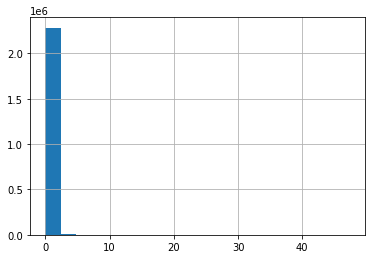

In [5]:
train['error'] = (train['pressure'] - train['pred']).abs()
train.loc[train.u_out>0,'error'] = 0
train.loc[train.u_out==0,'error'].hist(bins=20)

In [6]:
maxdrift = train.loc[train.u_out==0,'error'].mean() + 3*train.loc[train.u_out==0,'error'].std()
maxdrift

1.0997524342216412

- According the host paper https://arxiv.org/pdf/2102.06779.pdf, only the terms P and I were used in the PID simulations.
- Hosts gives P, I and Setpoints used in appendinx A.2

In [7]:
p_coef = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
i_coef = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
setpoints = [10, 15, 20, 25, 30, 35]

In [8]:
unique_pressures = train['pressure'].round(decimals=7).unique()
unique_pressures = list(np.sort(unique_pressures))
len(unique_pressures), unique_pressures[:10]

(950,
 [-1.8957443,
  -1.8254421,
  -1.75514,
  -1.6848379,
  -1.6145357,
  -1.5442336,
  -1.4739314,
  -1.4036293,
  -1.3333271,
  -1.263025])

In [9]:
maxdrift / (unique_pressures[1]-unique_pressures[0])

15.643215066123698

In [10]:
max_pressure = 64.82099173863328
min_pressure = -1.895744294564641
diff_pressure = 0.0703021454512

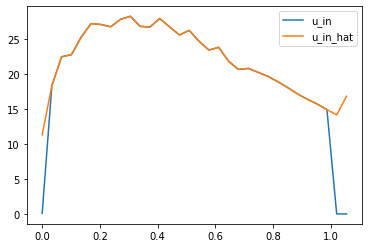

In [11]:
def generate_u_in(pressure, time_step, kp, ki, kt, integral=0):
    dt = np.diff(time_step, prepend=[0])
    preds = []
    for j in range(32):
        error = kt - pressure[j]
        integral += (error - integral) * (dt[j] / (dt[j] + 0.5))
        preds.append(kp * error + ki * integral)
    return preds

pressure = train[train['breath_id'] == 1]['pressure'].values 
timestep = train[train['breath_id'] == 1]['time_step'].values
u_in = generate_u_in(pressure, timestep, 0.8, 8.0, 20)
noise = train[train['breath_id'] == 1]['u_in'].values[:32] - u_in

plt.figure()
plt.plot(timestep[:32], train[train['breath_id'] == 1]['u_in'].values[:32], label='u_in')
plt.plot(timestep[:32], u_in, label='u_in_hat')
plt.legend()
plt.show()

In [12]:
# Ps = train['pressure'].unique()
# Ps = np.sort(Ps)
# P1s = Ps
# P2s = Ps[:, None]
# PDiff = P1s-P2s

# def fill_gaps_b(kp, ki, kt, u_in, dts):
#     us = np.zeros(80, dtype='float64') - 9
#     preds = np.zeros(80, dtype='float64') - 9
#     match = 0
#     for j in range(32):
#         u1, u2 = u_in[j], u_in[j+1]
#         ki2 = ki * dts[j+1] / (0.5 + dts[j+1])
#         u2_hat= u1+kp*PDiff + ki2*(kt-P2s-(u1-kp*(kt-P1s))/ki)
#         m = np.abs(u2 - u2_hat) <= 1e-7
#         if np.any(m):
#             us[j+1] = u2
#             if preds[j + 1] == -9:
#                 match += 1
#                 pos = np.where(m)[0][0]
#                 preds[j+1] = P2s[pos]
#     return preds, match

# pressure = train[train['breath_id'] == 1]['pressure'].values.copy()
# timestep = train[train['breath_id'] == 1]['time_delta'].values.copy()
# u_in = train[train['breath_id'] == 1]['u_in'].values.copy()
# plt.plot(pressure[:32])

# for P in p_coef:
#     for I in i_coef:
#         for SP in setpoints:
#             res, match = fill_gaps_b(P, I, SP, u_in, timestep )
#             if match>16:
#                 print(match, P, I, SP)

In [13]:
# Ps = train['pressure'].unique()
# Ps = np.sort(Ps)
# P1s = Ps
# P2s = Ps[:, None]
# PDiff = P1s-P2s

# def fill_gaps_b(kp, ki, kt, u_in, dts, ypred):
#     us = np.zeros(80, dtype='float64') - 9
#     preds = np.zeros(80, dtype='float64') - 9
#     match = 0
#     for j in range(1,32):
#         u1, u2 = u_in[j], u_in[j+1]
#         ki2 = ki * dts[j+1] / (0.5 + dts[j+1])
#         vmin = np.min(ypred[j:j+2])
#         vmax = np.max(ypred[j:j+2])
#         pi = np.clip(vmin - 2.0, min_pressure, max_pressure)
#         pe = np.clip(vmax + 2.0, min_pressure, max_pressure)
#         pi = np.sum(Ps<=pi)
#         pe = np.sum(Ps<=pe)
#         u2_hat= u1 + kp*PDiff[pi:pe, pi:pe] + ki2*(kt-P2s[pi:pe]-(u1-kp*(kt-P1s[pi:pe]))/ki)
#         #print(u2.shape, u2_hat.shape)
#         m = np.abs(u2 - u2_hat) <= 1e-7
#         if np.any(m):
#             #print('hit')
#             us[j+1] = u2
#             if preds[j + 1] == -9:
#                 match += 1
#                 pos = np.where(m)[0][0]
#                 preds[j+1] = P2s[pi+pos]
            
        
#     return preds, match


In [14]:
# train['breath_id'].unique()

In [15]:
# def match_breath(u_in, u_out, timestep, kp, ki, kt):
#     dt = np.diff(timestep)
#     dt2 = dt / (dt + 0.5)
#     in_len = np.sum(1 - u_out)
#     preds = np.zeros(len(u_in)) - 999
    
#     for t in range(1, in_len):
#         # If we had a match in previous timestep, we can re-use that match
#         if preds[t - 1] != -999:
#             P0 = preds[t - 1]
#         else:
#             P0 = np.arange(MIN_PRESSURE, MAX_PRESSURE + DIFF_PRESSURE, DIFF_PRESSURE)
            
#         I0 = (u_in[t - 1] - kp * (kt - P0))/ki

#         # Calculate 2 points for our P1
#         I11 = I0 + (kt - MIN_PRESSURE - I0) * dt2[t-1]
#         u_in_hat1 = kp * (kt - MIN_PRESSURE) + ki * I11

#         I12 = I0 + (kt - MIN_PRESSURE2 - I0) * dt2[t-1]
#         u_in_hat2 = kp * (kt - MIN_PRESSURE2) + ki * I12

#         # Get slope and intersection point
#         slope = u_in_hat2 - u_in_hat1
#         x_intersect = (u_in[t] - u_in_hat2) / slope
        
#         # We want the intersection to be an integer
#         diff = np.abs(np.round(x_intersect) - x_intersect)
        
#         if diff.min() < 1e-10:
#             pos = np.argmin(diff)
            
#             if preds[t - 1] == -999:
#                 preds[t - 1] = P0[np.argmin(diff)]
#                 preds[t] = MIN_PRESSURE + int(x_intersect[pos] + 1) * DIFF_PRESSURE
#             else:
#                 preds[t] = MIN_PRESSURE + (np.round(x_intersect) + 1) * DIFF_PRESSURE
            
#     return preds

In [16]:
# i = 1
# pressure = train[train['breath_id'] == i]['pressure'].values.copy()
# timestep = train[train['breath_id'] == i]['time_delta'].values.copy()
# u_in = train[train['breath_id'] == i]['u_in'].values.copy()
# ypred = train[train['breath_id'] == i]['pred'].values.copy()

In [17]:
# %%timeit
# res, match = fill_gaps_b(1, 8, 20, u_in, timestep, ypred )

In [18]:
MAX_PRESSURE  = PRESSURE_MAX  = 64.82099173863328
MIN_PRESSURE  = PRESSURE_MIN  = -1.895744294564641
DIFF_PRESSURE = PRESSURE_STEP = 0.0703021454512
MIN_PRESSURE2 = PRESSURE_MIN2 = MIN_PRESSURE + DIFF_PRESSURE

def match_breath(u_in, u_out, timestep, kp, ki, kt):
    dt = np.diff(timestep)
    dt2 = dt / (dt + 0.5)
    in_len = np.sum(1 - u_out)
    preds = np.zeros(len(u_in)) - 999
    
    match=0
    for t in range(1, in_len):
        # If we had a match in previous timestep, we can re-use that match
        if preds[t - 1] != -999:
            P0 = preds[t - 1]
        else:
            P0 = np.arange(MIN_PRESSURE, MAX_PRESSURE + DIFF_PRESSURE, DIFF_PRESSURE)
            
        I0 = (u_in[t - 1] - kp * (kt - P0))/ki

        # Calculate 2 points for our P1
        I11 = I0 + (kt - MIN_PRESSURE - I0) * dt2[t-1]
        u_in_hat1 = kp * (kt - MIN_PRESSURE) + ki * I11

        I12 = I0 + (kt - MIN_PRESSURE2 - I0) * dt2[t-1]
        u_in_hat2 = kp * (kt - MIN_PRESSURE2) + ki * I12

        # Get slope and intersection point
        slope = u_in_hat2 - u_in_hat1
        x_intersect = (u_in[t] - u_in_hat2) / slope
        
        # We want the intersection to be an integer
        diff = np.abs(np.round(x_intersect) - x_intersect)
        
        if diff.min() < 1e-10:
            match+=1
            pos = np.argmin(diff)
            
            if preds[t - 1] == -999:
                preds[t - 1] = P0[np.argmin(diff)]
                preds[t] = MIN_PRESSURE + int(x_intersect[pos] + 1) * DIFF_PRESSURE
            else:
                preds[t] = MIN_PRESSURE + (np.round(x_intersect) + 1) * DIFF_PRESSURE
            
    return preds, match

In [19]:
i = 1
pressure = train[train['breath_id'] == i]['pressure'].values.copy()
timestep = train[train['breath_id'] == i]['time_step'].values.copy()
u_in = train[train['breath_id'] == i]['u_in'].values.copy()
u_out = train[train['breath_id'] == i]['u_out'].values.copy()
ypred = train[train['breath_id'] == i]['pred'].values.copy()

In [20]:
%%time
res, match = match_breath(u_in, u_out, timestep, 1, 8, 20)

CPU times: user 2.23 ms, sys: 821 µs, total: 3.05 ms
Wall time: 4.11 ms


In [21]:
import time
# starttime = time.time()
# count = 0
# for i in train['breath_id'].unique()[:10]:
#     count += 1
#     pressure = train[train['breath_id'] == i]['pressure'].values.copy()
#     timestep = train[train['breath_id'] == i]['time_step'].values.copy()
#     u_in = train[train['breath_id'] == i]['u_in'].values.copy()
#     u_out = train[train['breath_id'] == i]['u_out'].values.copy()
#     ypred = train[train['breath_id'] == i]['pred'].values.copy()
#     match = 0
#     for P in p_coef:
#         for I in i_coef:
#             for SP in setpoints:
#                 res, match = match_breath(u_in, u_out, timestep, P, I, SP)
#                 if match>24:
#                     print(i, count, match, P, I, SP, (time.time()-starttime), (time.time()-starttime)/count )
#                     break
#             if match>24:
#                 break
#         if match>24:
#             break   
#     print((time.time()-starttime)/count)
# #1 1 28 0.8 8 20 2.3033382892608643 2.3033394813537598

In [22]:
# %%time
# import time
# starttime = time.time()
# count = 0
# for i in train['breath_id'].unique()[:4]:
#     count += 1
#     pressure = train[train['breath_id'] == i]['pressure'].values.copy()
#     timestep = train[train['breath_id'] == i]['time_delta'].values.copy()
#     u_in = train[train['breath_id'] == i]['u_in'].values.copy()
#     ypred = train[train['breath_id'] == i]['pred'].values.copy()
#     match = 0
#     for P in p_coef:
#         for I in i_coef:
#             for SP in setpoints:
#                 res, match = fill_gaps_b(P, I, SP, u_in, timestep, ypred )
#                 if match>24:
#                     print(i, count, match, P, I, SP, (time.time()-starttime), (time.time()-starttime)/count )
#                     break
#             if match>24:
#                 break
#         if match>24:
#             break   
#     print()

In [23]:
# %%time
# import time
# starttime = time.time()
# count = 0
# for i in train['breath_id'].unique():
#     count += 1
#     pressure = train[train['breath_id'] == i]['pressure'].values.copy()
#     timestep = train[train['breath_id'] == i]['time_delta'].values.copy()
#     u_in = train[train['breath_id'] == i]['u_in'].values.copy()
#     ypred = train[train['breath_id'] == i]['pred'].values.copy()
#     match = 0
#     for P in p_coef:
#         for I in i_coef:
#             for SP in setpoints:
#                 res, match = fill_gaps_b(P, I, SP, u_in, timestep, ypred )
#                 if match>24:
#                     print(i, count, match, P, I, SP, (time.time()-starttime), (time.time()-starttime)/count )
#                     break
#             if match>24:
#                 break
#         if match>24:
#             break   
#     print()

In [24]:
starttime = time.time()

PIDTEST = []
count = 0
for i in test['breath_id'].unique()[:1000]:
    count += 1
    ids = test[test['breath_id'] == i]['id'].values.copy()
    timestep = test[test['breath_id'] == i]['time_step'].values.copy()
    u_in = test[test['breath_id'] == i]['u_in'].values.copy()
    u_out = test[test['breath_id'] == i]['u_out'].values.copy()
    #ypred = test[test['breath_id'] == i]['pred'].values.copy()
    match = 0
    for P in p_coef:
        for I in i_coef:
            for SP in setpoints:
                res, match = match_breath(u_in, u_out, timestep, P, I, SP)
                if match>24:
                    dt = pd.DataFrame({
                        'id': ids,
                        'breath_id': i,
                        'P': P,
                        'I': I,
                        'SP': SP,
                        'pressure': res,
                    })                    
                    PIDTEST.append(dt)
                    print(i, count, match, P, I, SP, (time.time()-starttime), (time.time()-starttime)/count )
                    break
            if match>24:
                break
        if match>24:
            break
            
PIDTEST = pd.concat(PIDTEST).reset_index(drop=True)
PIDTEST.shape

8 2 26 4 0.3 10 7.2381556034088135 3.619078040122986
56 11 29 0.6 0.5 25 41.2408242225647 3.749165881763805
62 12 29 0.4 0.3 20 42.13715314865112 3.511429488658905
74 14 26 2 6 20 48.80903625488281 3.486359783581325
78 15 28 3 7 25 51.506996393203735 3.4337998231252036
103 28 29 0.6 0.4 25 102.64363217353821 3.66584404025759
105 29 30 0.4 3 15 103.64001703262329 3.573793723665435
107 30 27 0.3 2 10 104.41840410232544 3.4806134939193725
124 37 28 5 3 15 132.34603142738342 3.5769197940826416
127 38 27 0.8 0.2 10 133.96043419837952 3.5252746029904016
140 43 27 0.2 0.5 15 151.07641172409058 3.5134049404499144
153 45 28 1 0.6 15 157.36467623710632 3.496992826461792
158 46 28 1 0.9 10 159.46073651313782 3.4665377658346426
178 52 27 5 0.4 20 182.83606791496277 3.5160782428888173
185 55 28 0.3 0.5 25 191.60563206672668 3.4837387735193426
195 57 25 0.6 7 35 196.97634267807007 3.4557253268727086
198 59 25 0.5 5 35 202.30687952041626 3.428930173485966
209 63 25 0.5 3 25 215.37729620933533 3.41868

(19600, 6)

In [25]:
# plt.plot(pressure[:32])
# plt.plot(res[:32])

In [26]:
PIDTEST.to_csv('pid-test-1.csv', index=False)

In [27]:
# P  = proportional term
# SP  = pressure set-point
# for PID output: Pressure = (Setpoint - u_in) * P

BIDtrain = []
for SP in setpoints:
    for P in p_coef:
        train['u_ctrl'] = ((SP - train['u_in']/P)).round(decimals=7)
        
        #Check is results falls in any of the 950 train pressure values
        train['isclass'] = 0
        train.loc[train['u_ctrl'].isin(unique_pressures), 'isclass'] = 1
        
        dt = train.loc[(train.u_out==0)&(train.dcount>=1)].groupby('breath_id')[['isclass','uo']].agg({'isclass':'sum', 'uo':'first'}).reset_index().sort_values('isclass', ascending=False).reset_index(drop=True)
        dt = dt.loc[dt['isclass']>=(dt['uo']-3)]
        if dt.shape[0]>0:
            print('matches:',dt.shape[0], 'P=',P, 'SP=', SP)
            dt['P'] = P
            dt['SP'] = SP
            BIDtrain.append(dt)
            

BIDtrain = pd.concat(BIDtrain)
#BIDtrain = BIDtrain.sort_values('error').reset_index(drop=True)
print(BIDtrain.shape)
BIDtrain.head(10)

matches: 2 P= 0.01 SP= 10
matches: 1 P= 0.1 SP= 10
matches: 4 P= 0.3 SP= 10
matches: 5 P= 0.4 SP= 10
matches: 11 P= 0.5 SP= 10
matches: 11 P= 0.6 SP= 10
matches: 17 P= 0.7 SP= 10
matches: 16 P= 0.8 SP= 10
matches: 21 P= 0.9 SP= 10
matches: 19 P= 1 SP= 10
matches: 18 P= 2 SP= 10
matches: 9 P= 3 SP= 10
matches: 4 P= 4 SP= 10
matches: 1 P= 5 SP= 10
matches: 2 P= 0.01 SP= 15
matches: 16 P= 0.1 SP= 15
matches: 16 P= 0.2 SP= 15
matches: 18 P= 0.3 SP= 15
matches: 14 P= 0.4 SP= 15
matches: 15 P= 0.5 SP= 15
matches: 21 P= 0.6 SP= 15
matches: 18 P= 0.7 SP= 15
matches: 18 P= 0.8 SP= 15
matches: 20 P= 0.9 SP= 15
matches: 20 P= 1 SP= 15
matches: 15 P= 2 SP= 15
matches: 13 P= 3 SP= 15
matches: 7 P= 4 SP= 15
matches: 5 P= 5 SP= 15
matches: 4 P= 6 SP= 15
matches: 2 P= 7 SP= 15
matches: 3 P= 8 SP= 15
matches: 1 P= 9 SP= 15
matches: 1 P= 10 SP= 15
matches: 2 P= 0.01 SP= 20
matches: 13 P= 0.1 SP= 20
matches: 23 P= 0.2 SP= 20
matches: 21 P= 0.3 SP= 20
matches: 16 P= 0.4 SP= 20
matches: 16 P= 0.5 SP= 20
ma

,breath_id,isclass,uo,P,SP
0,50459,29,30,0.01,10
1,58835,29,30,0.01,10
0,98080,29,30,0.10,10
0,92123,31,32,0.30,10
1,13229,31,32,0.30,10
2,41276,31,32,0.30,10
3,65481,29,30,0.30,10
0,72010,31,32,0.40,10
1,90365,31,32,0.40,10
2,89957,29,30,0.40,10


In [28]:
# P  = proportional term
# SP  = pressure set-point
# for PID output: Pressure = (Setpoint - u_in) * P
# Since testset doesn't have pressure, we know if the controller have the term P>0 and I==0, only if the results falls in any of the 950 different values of pressure found in train set.

BIDtest = []
for SP in setpoints:
    for P in p_coef:
        test['u_ctrl'] = ((SP - test['u_in']/P)).round(decimals=7)
        
        #Check is results falls in any of the 950 train pressure values
        test['isclass'] = 0
        test.loc[test['u_ctrl'].isin(unique_pressures), 'isclass'] = 1
        
        dt = test.loc[(test.u_out==0)&(test.dcount>=1)].groupby('breath_id')[['isclass','uo']].agg({'isclass':'sum', 'uo':'first'}).reset_index().sort_values('isclass', ascending=False).reset_index(drop=True)
        dt = dt.loc[dt['isclass']>=(dt['uo']-3)]
        if dt.shape[0]>0:
            print('matches:',dt.shape[0], 'P=',P, 'SP=', SP)
            dt['P'] = P
            dt['SP'] = SP
            BIDtest.append(dt)
            
BIDtest = pd.concat(BIDtest)
#BIDtest = BIDtest.sort_values(['P', 'SP']).reset_index(drop=True)
print(BIDtest.shape)
BIDtest.head(10)

matches: 1 P= 0.01 SP= 10
matches: 2 P= 0.1 SP= 10
matches: 3 P= 0.2 SP= 10
matches: 2 P= 0.3 SP= 10
matches: 4 P= 0.4 SP= 10
matches: 7 P= 0.5 SP= 10
matches: 10 P= 0.6 SP= 10
matches: 7 P= 0.7 SP= 10
matches: 11 P= 0.8 SP= 10
matches: 9 P= 0.9 SP= 10
matches: 11 P= 1 SP= 10
matches: 10 P= 2 SP= 10
matches: 5 P= 3 SP= 10
matches: 4 P= 4 SP= 10
matches: 2 P= 5 SP= 10
matches: 1 P= 0.01 SP= 15
matches: 14 P= 0.1 SP= 15
matches: 14 P= 0.2 SP= 15
matches: 12 P= 0.3 SP= 15
matches: 13 P= 0.4 SP= 15
matches: 15 P= 0.5 SP= 15
matches: 6 P= 0.6 SP= 15
matches: 12 P= 0.7 SP= 15
matches: 9 P= 0.8 SP= 15
matches: 10 P= 0.9 SP= 15
matches: 10 P= 1 SP= 15
matches: 10 P= 2 SP= 15
matches: 4 P= 3 SP= 15
matches: 1 P= 4 SP= 15
matches: 2 P= 5 SP= 15
matches: 1 P= 6 SP= 15
matches: 1 P= 7 SP= 15
matches: 2 P= 9 SP= 15
matches: 2 P= 10 SP= 15
matches: 1 P= 0.01 SP= 20
matches: 17 P= 0.1 SP= 20
matches: 7 P= 0.2 SP= 20
matches: 9 P= 0.3 SP= 20
matches: 11 P= 0.4 SP= 20
matches: 14 P= 0.5 SP= 20
matches:

,breath_id,isclass,uo,P,SP
0,33528,29,30,0.01,10
0,25838,29,30,0.10,10
1,82421,29,30,0.10,10
0,23074,29,30,0.20,10
1,106489,29,30,0.20,10
2,70268,29,30,0.20,10
0,9665,29,30,0.30,10
1,2396,29,30,0.30,10
0,94740,31,32,0.40,10
1,3967,31,32,0.40,10


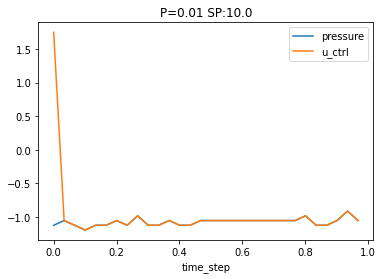

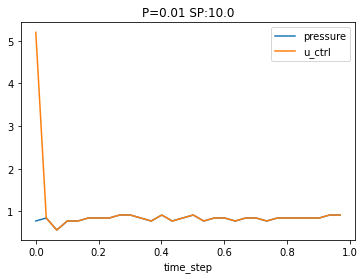

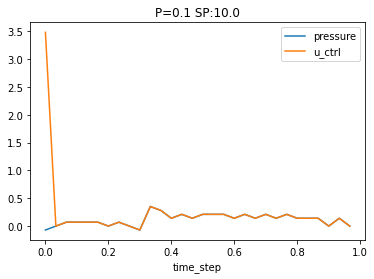

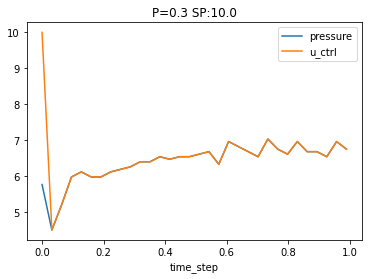

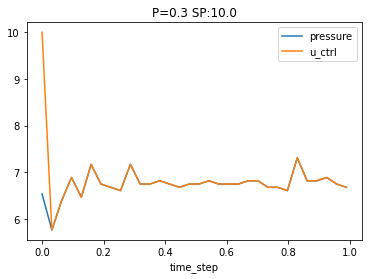

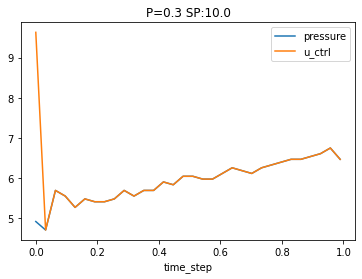

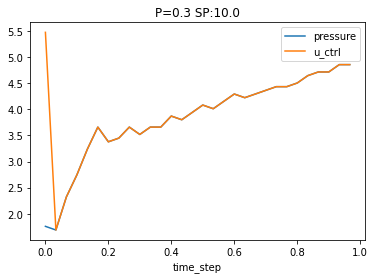

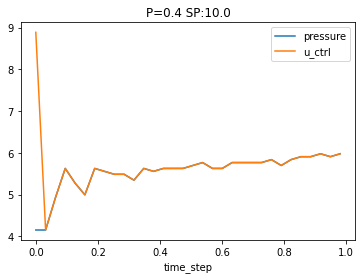

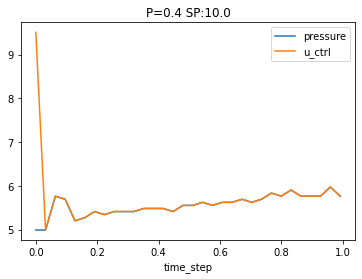

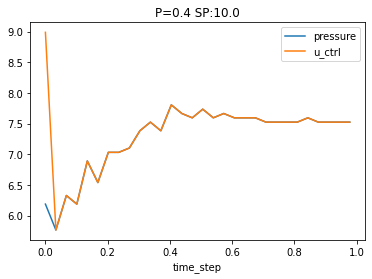

In [29]:
#for i in range(BIDtrain.shape[0]):
for i in range(10):
    bid = BIDtrain.iloc[i]
    P = bid.P
    SP = bid.SP
    tmp = train.loc[train.breath_id == bid.breath_id].copy()
    tmp['u_ctrl'] =  (SP - tmp['u_in']/P)
    tmp.loc[(tmp.u_out==0)&(tmp.dcount>=0)].plot( x='time_step', y=['pressure', 'u_ctrl'], title = 'P='+str(P) + ' SP:'+str(SP) )

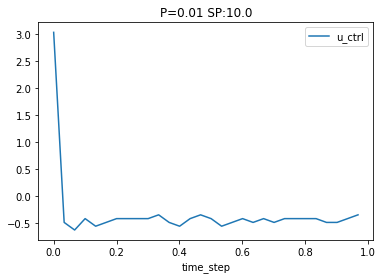

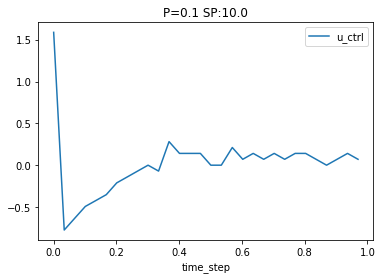

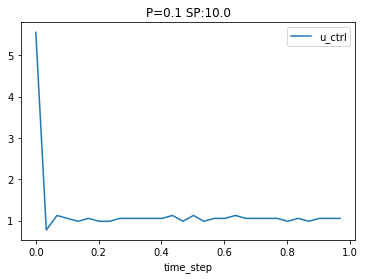

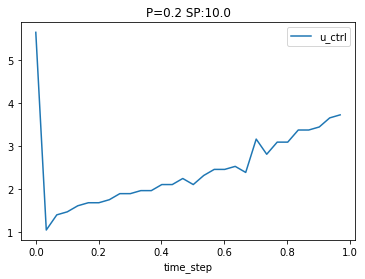

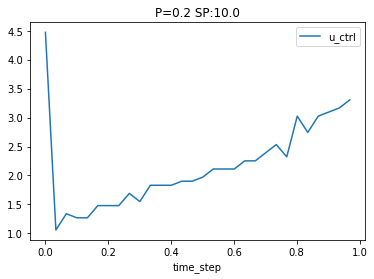

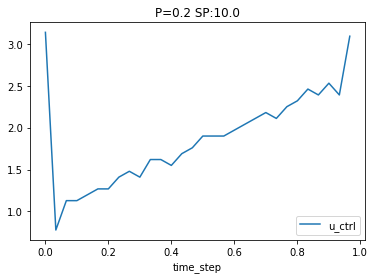

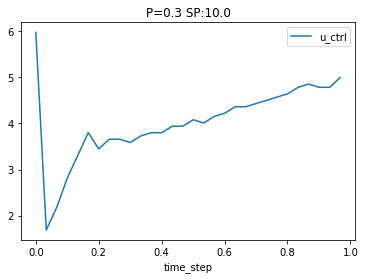

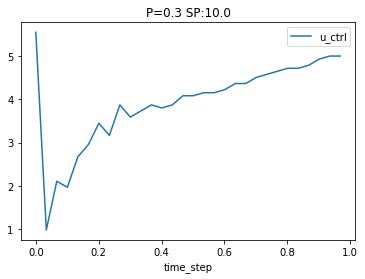

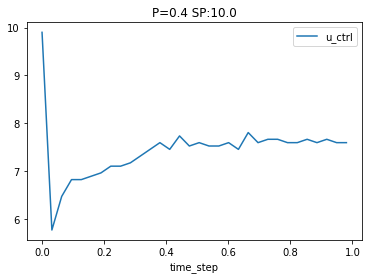

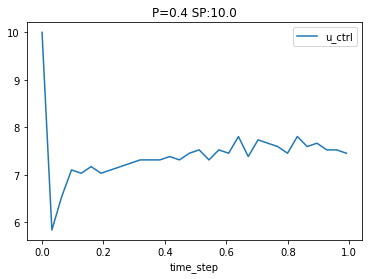

In [30]:
#for i in range(BIDtest.shape[0]):
for i in range(10):
    bid = BIDtest.iloc[i]
    P = bid.P
    SP = bid.SP
    tmp = test.loc[test.breath_id == bid.breath_id].copy()
    tmp['u_ctrl'] =  (SP - tmp['u_in']/P)
    tmp.loc[(tmp.u_out==0)&(tmp.dcount>=0)].plot( x='time_step', y=['u_ctrl'], title = 'P='+str(P) + ' SP:'+str(SP) )

In [31]:
test.head()

,id,breath_id,R,C,time_step,u_in,u_out,dcount,uo,time_delta,pred,u_ctrl,isclass
0,1,0,5,20,0.000000,0.000000,0,0,31,0.000000,6.329607,35.000000,0
1,2,0,5,20,0.031904,7.515046,0,1,31,0.031904,5.978096,34.248495,0
2,3,0,5,20,0.063827,14.651675,0,2,31,0.031924,7.102930,33.534833,0
3,4,0,5,20,0.095751,21.230610,0,3,31,0.031924,7.595045,32.876939,0
4,5,0,5,20,0.127644,26.320956,0,4,31,0.031893,9.141693,32.367904,0


In [32]:
test = test.merge(BIDtest[['breath_id','P','SP']],on='breath_id',how='left')
test['pred'] = (test.SP - test['u_in']/test.P).round(decimals=7)
test_ids = BIDtest.breath_id.values

tmp = test.loc[(test.dcount>0)&(test.breath_id.isin(test_ids))]
tmp

,id,breath_id,R,C,time_step,u_in,u_out,dcount,uo,time_delta,pred,u_ctrl,isclass,P,SP
5601,5602,236,20,20,0.033921,5.286599,0,1,29,0.033921,6.189002,34.471340,0,0.6,15.0
5602,5603,236,20,20,0.067960,4.569517,0,2,29,0.034039,7.384139,34.543048,0,0.6,15.0
5603,5604,236,20,20,0.101773,4.822604,0,3,29,0.033813,6.962326,34.517740,0,0.6,15.0
5604,5605,236,20,20,0.135964,4.780423,0,4,29,0.034192,7.032628,34.521958,0,0.6,15.0
5605,5606,236,20,20,0.170105,4.738242,0,5,29,0.034141,7.102930,34.526176,0,0.6,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4020155,4020156,125628,5,10,2.532554,4.971610,1,75,30,0.033734,21.713983,34.502839,0,0.6,30.0
4020156,4020157,125628,5,10,2.566155,4.976001,1,76,30,0.033601,21.706666,34.502400,0,0.6,30.0
4020157,4020158,125628,5,10,2.600072,4.979744,1,77,30,0.033917,21.700427,34.502026,0,0.6,30.0
4020158,4020159,125628,5,10,2.633744,4.982883,1,78,30,0.033673,21.695195,34.501712,0,0.6,30.0


In [33]:
sub = pd.read_csv('../input/ventmodels/Exp-102-ResBiLSTM-v2-CustomLoss-v1-AdamW-LogUin-30Fold-Seed2025-FineTune.csv')

sub = sub.merge(tmp[['id','pred']],on='id',how='left')

sub.loc[sub.pred.notna(),'pressure'] = sub.loc[sub.pred.notna(),'pred']

del sub['pred']
sub

,id,pressure
0,1,6.399909
1,2,5.978096
2,3,7.173232
3,4,7.665347
4,5,9.211995
...,...,...
4023995,4023996,6.189002
4023996,4023997,6.259305
4023997,4023998,6.399909
4023998,4023999,6.189002


In [34]:
tmp = pd.read_csv('pid-test-1.csv')
tmp = tmp.loc[ tmp.pressure > - 999, ['id','pressure'] ].reset_index(drop=True)
tmp.columns = ['id', 'pred']
tmp.head()

,id,pred
0,81,5.907794
1,82,7.102930
2,83,6.540513
3,84,7.665347
4,85,6.821722


In [35]:
sub = sub.merge(tmp[['id','pred']],on='id',how='left')
sub.loc[sub.pred.notna(),'pressure'] = sub.loc[sub.pred.notna(),'pred']

del sub['pred']
sub

,id,pressure
0,1,6.399909
1,2,5.978096
2,3,7.173232
3,4,7.665347
4,5,9.211995
...,...,...
4023995,4023996,6.189002
4023996,4023997,6.259305
4023997,4023998,6.399909
4023998,4023999,6.189002


In [36]:
sub.to_csv('submission-postprocessing.csv', index=False)